# Classificação

Nesta etapa iremos criar um modelo capaz de classificar uma nova entrada de dados de clientes ao nosso perfíl selecionado na etapa anterior de clusterização.

Aqui faremos iremos pré-processar os nossos dados para a implementação de modelos de classificação como SVM (Support Verctor Machines), Árvores de Decisão e Regressão Logística e por fim vamos medir o desempenho de cada algoritmo e ver qual se ajusta melhor aos nossos dados.

In [1]:
# importando bibliotecas
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv(os.getcwd().replace('code','data')+'\\processed\\data_clusterized.csv')
data

,id,sex,marital_status,age,education,income,occupation,settlement_size,cluster
0,100000001,0,0,4.204693,2,11.733426,1,2,0
1,100000002,1,1,3.091042,1,11.923531,1,2,2
2,100000003,0,0,3.891820,1,11.398748,0,0,4
3,100000004,0,0,3.806662,1,12.052717,1,1,0
4,100000005,0,0,3.970292,1,11.911910,1,1,0
...,...,...,...,...,...,...,...,...,...
1995,100001996,1,0,3.850148,1,11.724199,0,0,4
1996,100001997,1,1,3.295837,1,11.676268,1,0,3
1997,100001998,0,0,3.433987,0,11.366743,0,0,1
1998,100001999,1,1,3.178054,1,11.492396,0,0,3


- Lembrando que os valores de `age` e `income` estão logatitimados, caso precisemos voltar a escola normal basta elevar expoente.

In [3]:
# transformando clusters na nossa variável alvo
for i in range(len(data['cluster'])):
    if data['cluster'][i] == 0:
        data['cluster'][i] = 1
    else:
        data['cluster'][i] = 0

In [4]:
data.rename(columns={'cluster' : 'target'}, inplace=True) # renomea coluna

In [5]:
# a coluna 'id' não nos é útil portanto iremos remove-la
data.drop(columns='id', inplace=True)

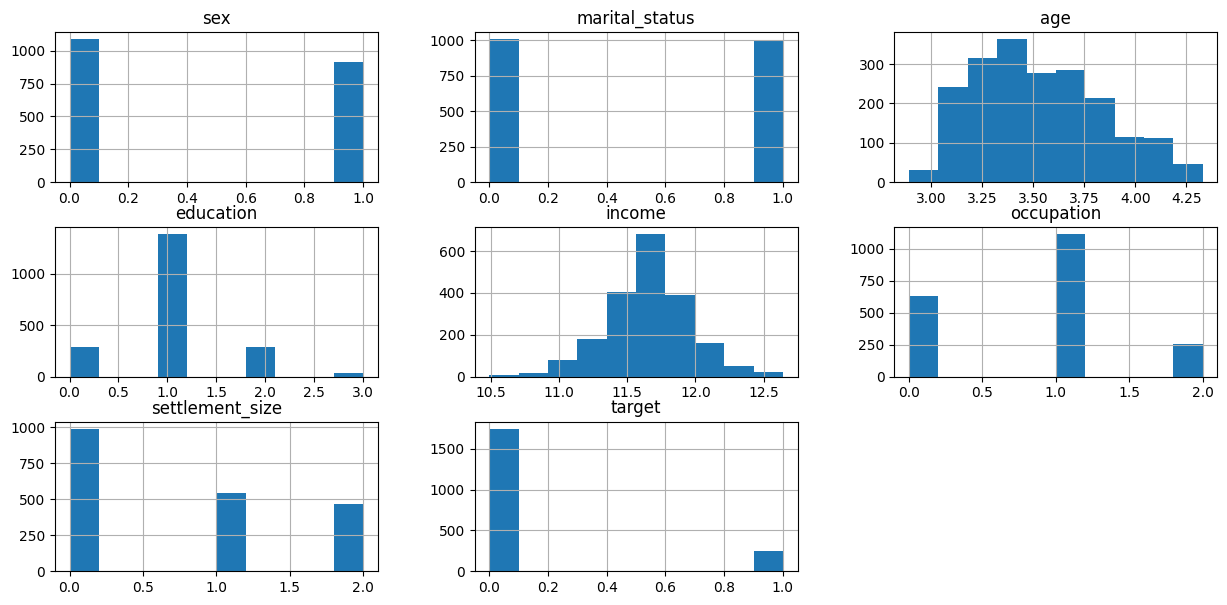

In [6]:
# analizando a distribuição
data.hist(figsize=(15,7));

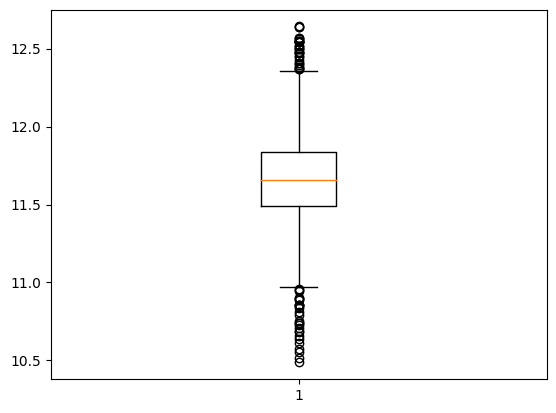

In [7]:
plt.boxplot(data['income']);

- Para remover alguns desses outliers e melhorar o desempenho dos nossos modelos, utilizaremos o método de calculo interquartílíco para defininr os limites superiores e inferiores dos dados e remover os que excederem.

In [8]:
q3 = data['income'].quantile(0.75)
q1 = data['income'].quantile(0.25)

iqr = q3-q1

iqr2 = iqr * 1.5

limite_sup = q3 + iqr2
limite_inf = q1 - iqr2

In [9]:
data = data[(data['income'] > limite_inf) & (data['income'] < limite_sup)]

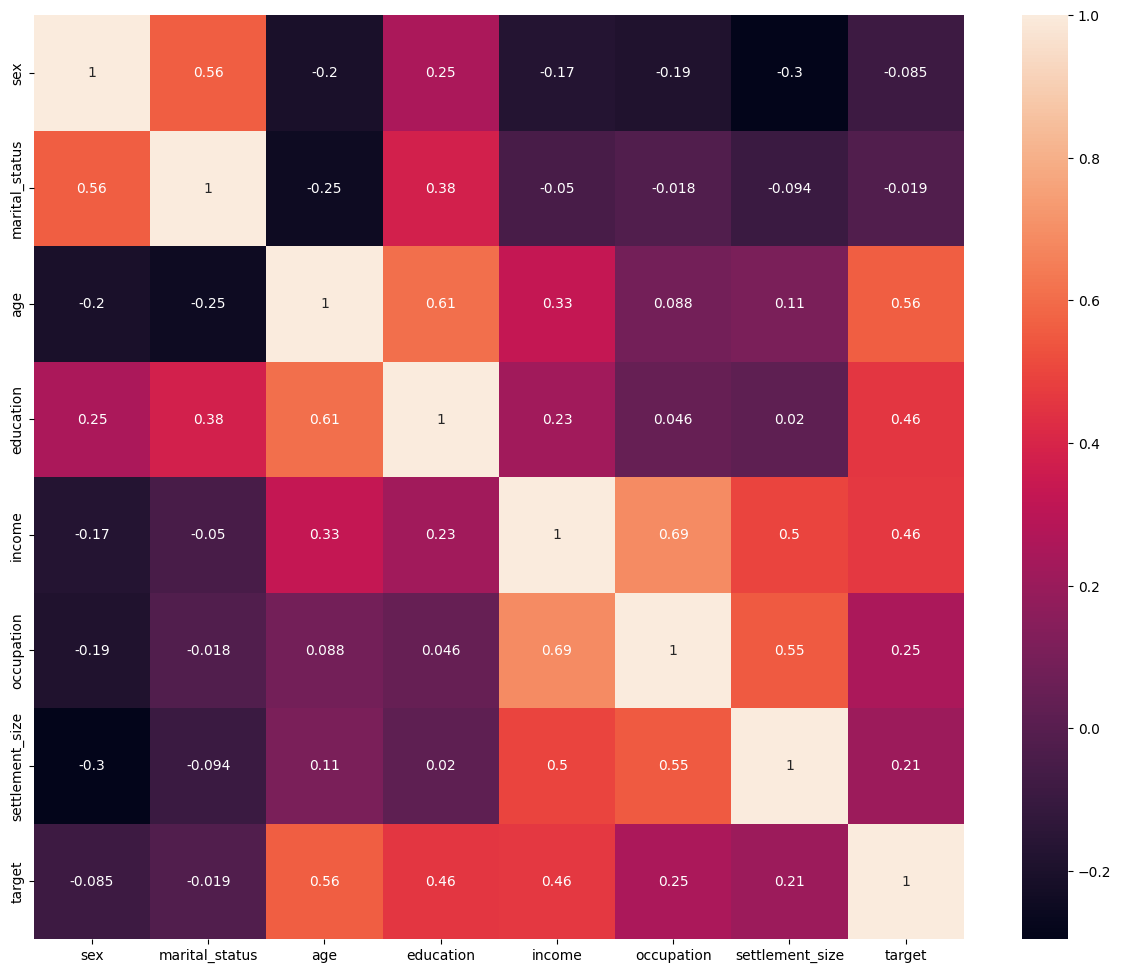

In [10]:
# analizando correlações com a variável alvo
plt.figure(figsize=(15,12))
sns.heatmap(data.corr(), annot=True)
plt.show()

- As colunas que apresentam maior correlação com nosso grupo alvo são `age`, `education` e `income`.

In [11]:
# calcula a porcentagem de classe da coluna 'target'
print(f"{(data['target'].value_counts() / len(data['target']) * 100)}%")

target
0    88.150438
1    11.849562
Name: count, dtype: float64%


- Percebemos um grande desbalanceamento nas classes alvo, isso deve prejudicar nosso modelo de classificação, portanto seremos obrigados a balancear as classes para um melhor desempenho dos modelos.

- Para resolver esta problema poderemos utilizar meios como OverSampling ou UnderSampling para balancear as classes. Mas há outro fator aqui, possuimos apenas 2000 entradas de dados, o que é uma quantidade muito pequena para utilizar o UnderSample que funciona reduzindo a quantidade da classe majoritária para se equiparar com a minoritária. Isso resultaria em uma perda significativa nos dados, algo que prejudicaria nosso modelo. Como saída para este problema utilizaremos o OverSampling para "criar dados fictícios" na nossa base de treino.

 - Vale lembrar que não podemos utilizar esse método de balanceamento na nosa base de teste, pois nosso objetivo é apenas treinar o modelo fazendo com que ele acerte o máximo possível ao invés de envieza-lo.

In [12]:
# separando treino e teste
x = data.drop(columns='target', axis=1)
y = data['target']

x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=42)

In [13]:
x_train.shape, y_train.shape

((1358, 7), (1358,))

In [14]:
y_train.value_counts()

target
0    1191
1     167
Name: count, dtype: int64

#### Aplicando OverSampling

In [15]:
ros = RandomOverSampler(random_state=42)
x_train, y_train = ros.fit_resample(x_train,y_train)

In [16]:
x_train.shape, y_train.shape

((2382, 7), (2382,))

In [17]:
y_train.value_counts()

target
0    1191
1    1191
Name: count, dtype: int64

- Perceba que a quantidade de dados aumentou, isso se deve por que o método de OverSampling criou uma quantidade de dados da categoria minoritária para se igualar à majoritária.

# Algoritmos de Classificação

In [18]:
# atribui escalonador RobustScaler
r_scaler = RobustScaler()

# define o numero de iterações na nossa validação cruzada
kf = KFold(n_splits=10, shuffle=True, random_state=42)

## Regressão Logística

#### Treinando modelo

In [19]:
# atribui modelo de Regressão Logística
model_lr = LogisticRegression(random_state=42)

# cria pipeline de processamento
pipeline_lr = make_pipeline(r_scaler, model_lr)

# treina os dados
pipeline_lr.fit(x_train, y_train)

# fazendo previsões nos dados de teste
y_pred_lr = pipeline_lr.predict(x_test)

#### Validando modelo

In [20]:
# calcula acurácia
accuracy_lr = accuracy_score(y_test, y_pred_lr)

# calcula matriz de confusão
cm_lr = confusion_matrix(y_test, y_pred_lr)

# validação cruzada com 5 folds
scores_lr = cross_val_score(pipeline_lr, x_train, y_train, cv=5, scoring = 'accuracy')

#### Vizualizando desempenho

F1-score e Recall
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       520
           1       0.76      0.97      0.85        63

    accuracy                           0.96       583
   macro avg       0.88      0.97      0.92       583
weighted avg       0.97      0.96      0.97       583

--------------------------------------------------------------------------------
A acurácia do modelo de Regressão Logística é 0.9639794168096055
--------------------------------------------------------------------------------
Validação Cruzada
A acurácia por fold na validação cruzada: [0.96645702 0.96645702 0.97478992 0.96638655 0.98109244]
A acurácia média CV: 0.97
--------------------------------------------------------------------------------


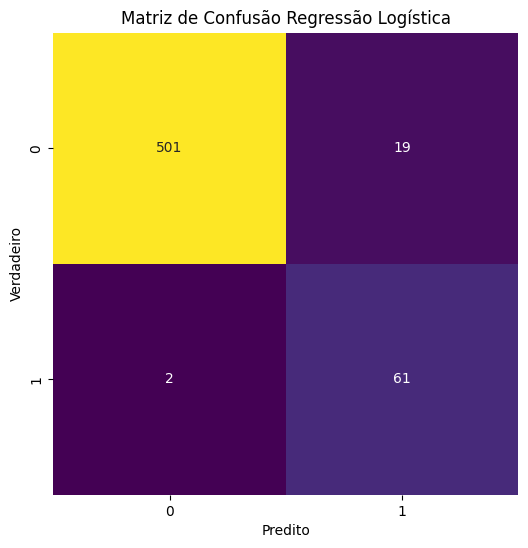

In [21]:
# exibe F1-score e Recall
print('F1-score e Recall')
print(classification_report(y_test, y_pred_lr))
print('-'*80)

# exibe acurácia
print('A acurácia do modelo de Regressão Logística é', accuracy_lr)
print('-'*80)

# exibe validação cruzada
print('Validação Cruzada')
print('A acurácia por fold na validação cruzada:', scores_lr)
print('A acurácia média CV:', round(scores_lr.mean(), 2))
print('-'*80)

# exibe martiz de confusão
plt.figure(figsize=(6,6))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap=('viridis'), cbar=False)
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão Regressão Logística')
plt.show()

____

## SVM (Support Vector Machine)

#### Treinando o modelo

In [22]:
# criando modelo SVM
model_svm = SVC(kernel='rbf')

# criando pipeline
pipeline_svm = make_pipeline(r_scaler, model_svm)

# ajustando modelo aos dados de treino
pipeline_svm.fit(x_train,y_train)

# fazendo previsões nos dados de teste
y_pred_svm = pipeline_svm.predict(x_test)

#### Validando o modelo

In [23]:
# calculando acurácia
accuracy_svm = accuracy_score(y_test, y_pred_svm)

# calculando matriz de confusão
cm_svm = confusion_matrix(y_test, y_pred_svm)

# validação cruzada com 5 folds
scores_svm = cross_val_score(pipeline_svm, x_train, y_train, cv=5, scoring = 'accuracy')

#### Vizualisando desempenho

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       520
           1       0.85      1.00      0.92        63

    accuracy                           0.98       583
   macro avg       0.93      0.99      0.95       583
weighted avg       0.98      0.98      0.98       583

--------------------------------------------------------------------------------
A acurácia do modelo SVM é: 0.9811320754716981
--------------------------------------------------------------------------------
Validação Cruzada
A acurácia por fold na validação cruzada: [0.98742138 0.98742138 0.98529412 0.98319328 0.98109244]
A acurácia média CV: 0.98
--------------------------------------------------------------------------------


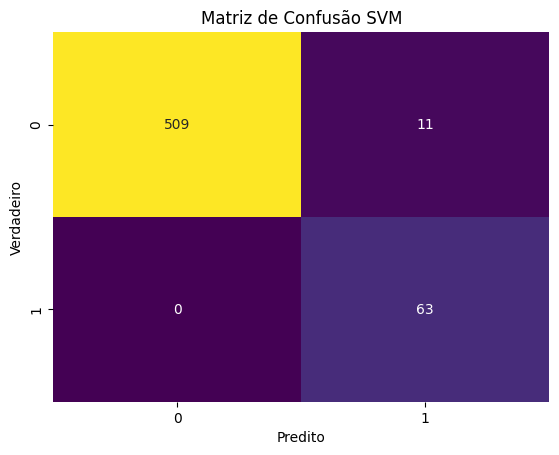

In [24]:
# exibindo F1-Score e Recall
print(classification_report(y_test, y_pred_svm))
print('-'*80)

# exibindo a acurácia
print('A acurácia do modelo SVM é:', accuracy_svm)
print('-'*80)

# exibe validação cruzada
print('Validação Cruzada')
print('A acurácia por fold na validação cruzada:',scores_svm)
print('A acurácia média CV:', round(scores_svm.mean(), 2))
print('-'*80)

# exibe matriz de confusão
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='viridis', cbar=False)
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão SVM')
plt.show()

____

## Árvores de Decisão

#### Descobrindo melhores hiperparâmetros

In [25]:
# atribuindo modelo
model_dt = DecisionTreeClassifier(random_state=42)

# definindo hiperparâmetros a serem testados
param_grid_dt = {
    'max_depth': [2, 3, 5, 10, None],
    'min_samples_split': [2,10,20],
    'min_samples_leaf': [ 1,5,10],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2']
}

# GridSearchCv com validação cruzada em 5 folds
grid_search_dt = GridSearchCV(estimator=model_dt, param_grid=param_grid_dt, cv=5, scoring='accuracy',n_jobs=-1)

# ajusta GridSearch aos dados de treino
grid_search_dt.fit(x_train, y_train)

# melhores hiperparâmetros
print('Melhores hiperparâmetros:', grid_search_dt.best_params_)

# melhor pontuação de validação cruzada
print('Melhor acurácia obtida:', grid_search_dt.best_score_)


Melhores hiperparâmetros: {'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Melhor acurácia obtida: 0.9979018022303261


#### Treinando modelo

In [26]:
# atribuindo modelo com melhores hiperparâmetros
model_dt2 = DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=2, random_state=42)

# criando pipeline de árvore de decisão
pipeline_dt = make_pipeline(r_scaler, model_dt2)

# ajustando modelo aos dados de treino
pipeline_dt.fit(x_train, y_train)

# prevendo dados de teste
y_pred_dt = pipeline_dt.predict(x_test)

#### Avaliando modelo de Árvore de Decisão

In [27]:
# calcula a acurácia
accuracy_dt = accuracy_score(y_test,y_pred_dt)

# calcaula matriz de confusão
cm_dt = confusion_matrix(y_test, y_pred_dt)

# validação cruzada com 5 folds
scores_dt = cross_val_score(pipeline_dt, x_train, y_train, cv=5, scoring = 'accuracy')

#### Vizualizando desempenho

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       520
           1       0.97      0.98      0.98        63

    accuracy                           0.99       583
   macro avg       0.98      0.99      0.99       583
weighted avg       0.99      0.99      0.99       583

--------------------------------------------------------------------------------
A acurácia do modelo de Árvore de Decisão é: 0.9948542024013722
--------------------------------------------------------------------------------
Validação Cruzada
A acurácia por fold na validação cruzada: [0.99790356 0.99580713 1.         0.99789916 0.99789916]
A acurácia média CV: 1.0
--------------------------------------------------------------------------------


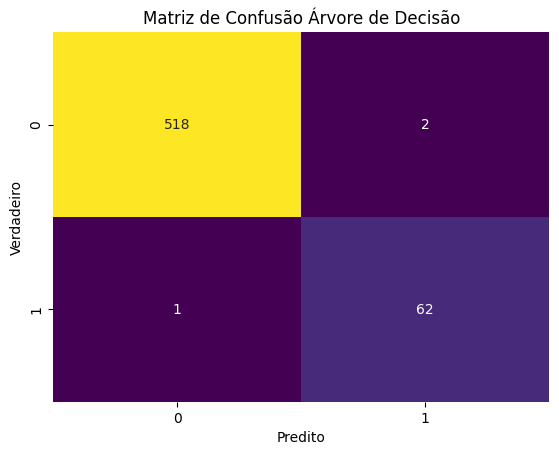

In [28]:
# exibindo F1-Score e Recall
print(classification_report(y_test, y_pred_dt))
print('-'*80)

# exibindo acurácia
print('A acurácia do modelo de Árvore de Decisão é:', accuracy_dt)
print('-'*80)

# exibe validação cruzada
print('Validação Cruzada')
print('A acurácia por fold na validação cruzada:',scores_dt)
print('A acurácia média CV:', round(scores_dt.mean(), 2))
print('-'*80)

# exibindo matriz de confusão
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='viridis', cbar=False)
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão Árvore de Decisão')
plt.show()